In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time

# Load the dataset

In [21]:
# import the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Print some examples

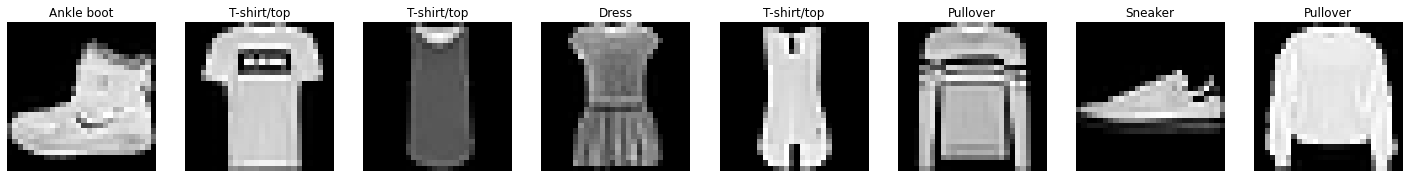

In [22]:
fig, ax = plt.subplots(1,8, figsize=(25, 25))
labels = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])

for i in range(8):

  img = train_images[i]
  label = labels[train_labels[i]]

  ax[i].imshow(img, cmap='gray')
  ax[i].set_title(label)
  ax[i].axis('off')

# Input Pipeline

In [23]:
### for train dataset
# create tf.Dataset for training dataset
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
# cast the images to float to allow for image normalization (they are uint8 before and we need the
# values to be in the continous range)
train_dataset_images = train_dataset_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
# normalize the images
train_dataset_images = train_dataset_images.map(lambda img : (img/255))
# create tf.Dataset for training labels
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels)

# zip labels and images together again
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_labels))
# batching
train_dataset = train_dataset.batch(64)
# prefetch
train_dataset = train_dataset.prefetch(32)
# shuffle the images
train_dataset = train_dataset.shuffle(buffer_size=128)

### now the test dataset
# create tf.Dataset for test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
# cast to float
test_dataset_images = test_dataset_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
# normalize the images
test_dataset_images = test_dataset_images.map(lambda img : (img/255))
# create tf.Dataset for training labels
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)

# zip labels and images together again
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_labels))
# batching
test_dataset = test_dataset.batch(64)
# prefetch
test_dataset = test_dataset.prefetch(32)
# shuffle the images
test_dataset = test_dataset.shuffle(buffer_size=128)

# Encoder

In [24]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Encoder(Model):

  def __init__(self):
    super(Encoder, self).__init__()

    # convolutional layers
    self.conv1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                        input_shape = (28,28,1),
                                        padding = "same",
                                        #kernel_regularizer = tf.keras.regularizers.l2(0.01),
                                        activation = None,
                                        kernel_initializer=tf.keras.initializers.glorot_normal(),
                                        )
    
    self.conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                        padding = "same",
                                        #kernel_regularizer = tf.keras.regularizers.l2(0.01),
                                        activation = None,
                                        kernel_initializer=tf.keras.initializers.glorot_normal(),
                                        )
    
    # batch normalizing layers
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.batch_norm3 = tf.keras.layers.BatchNormalization()

    # pooling layers
    self.pool1 = tf.keras.layers.MaxPool2D()
    self.pool2 = tf.keras.layers.MaxPool2D()

    # activations
    self.elu1 = tf.keras.activations.elu
    self.elu2 = tf.keras.activations.elu
    self.sigmoid = tf.keras.activations.sigmoid

    # flatten
    self.flatten = tf.keras.layers.Flatten()

    # Dense layer
    self.dense_layer = tf.keras.layers.Dense(10, activation = None,
                                             kernel_initializer=tf.keras.initializers.glorot_normal(),)
                                             #kernel_regularizer = tf.keras.regularizers.l2(0.01))


  @tf.function
  def call(self, x, training=True):
    x = self.conv1(x)
    x = self.batch_norm1(x, training)
    x = self.elu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.batch_norm2(x, training)
    x = self.elu2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dense_layer(x)
    x = self.batch_norm3(x, training)
    x = self.sigmoid(x)

    return x

# Decoder

In [25]:
class Decoder(Model):

  def __init__(self):
    super(Decoder, self).__init__()

    self.dense_layer = tf.keras.layers.Dense(units=7*7*1,
                                             #kernel_regularizer = tf.keras.regularizers.l2(0.01), 
                                             kernel_initializer=tf.keras.initializers.glorot_normal(),
                                             activation = None)

    self.reshape = tf.keras.layers.Reshape((7,7,1))
    # define the transposed convolutional layer
    self.trans_cov1 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size=3,
                                                      padding = "same",
                                                      strides = 2,
                                                      #kernel_regularizer = tf.keras.regularizers.l2(0.01),
                                                      kernel_initializer=tf.keras.initializers.glorot_normal(),
                                                      activation = None)
  
    self.trans_cov2 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size=3,
                                                      padding = "same",
                                                      strides = 2,
                                                      #kernel_regularizer = tf.keras.regularizers.l2(0.01),
                                                      kernel_initializer=tf.keras.initializers.glorot_normal(),
                                                      activation = None)
    
    self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3,
                                               padding = "same",
                                               kernel_initializer=tf.keras.initializers.glorot_normal(),
                                               #kernel_regularizer = tf.keras.regularizers.l2(0.01),
                                               activation = None)
    
    # activations
    self.sigmoid1 = tf.keras.activations.sigmoid
    self.elu1 = tf.keras.activations.elu
    self.elu2 = tf.keras.activations.elu
    self.sigmoid2 = tf.keras.activations.sigmoid

    # batch normalizing layers
    self.batch1 = tf.keras.layers.BatchNormalization()
    self.batch2 = tf.keras.layers.BatchNormalization()
    self.batch3 = tf.keras.layers.BatchNormalization()    
    self.batch4 = tf.keras.layers.BatchNormalization()

  @tf.function
  def call(self, x, training=True):
    x = self.dense_layer(x)
    x = self.batch1(x, training)
    x = self.sigmoid1(x)
    x = self.reshape(x)
    x = self.trans_cov1(x)
    x = self.batch2(x, training)
    x = self.elu1(x)
    x = self.trans_cov2(x)
    x = self.batch3(x, training)
    x = self.elu2(x)
    x = self.output_layer(x)
    x = self.batch4(x, training)
    x = self.sigmoid2(x)

    return x


# Autoencoder

In [26]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  @tf.function
  def call(self, x, training=True):
    x = self.encoder(x, training)
    x = self.decoder(x, training)

    return x

  def getEncoder(self):
    return self.encoder

  def getDecoder(self):
    return self.decoder


In [27]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
from IPython import display 

def plot(train_losses, test_losses, figsize=(10,3)):
  #display.clear_output(wait=True)

  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
  axes.plot(train_losses, label="training")
  axes.plot(test_losses, label="test")
  axes.set_xlabel("Epochs")
  axes.set_ylabel("Loss")
  axes.set_ylim([0,0.1])
  axes.set_title("Loss", fontsize=20)
  axes.legend()
  plt.show()

In [28]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

# Train step and test step

In [29]:
def train_step(model, input, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
      prediction = model(input, training)
      loss = loss_function(input, prediction) 
      gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_loss_aggregator = []

  for (input,_) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(input, prediction) 
    
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss

# Training

In [30]:
def train(model):
  tf.keras.backend.clear_session()

  ### Hyperparameters
  num_epochs = 15
  learning_rate = 0.001
  running_average_factor = 0.95

  # Initialize the model.
  #model = AutoEncoder()
  # Initialize the loss: . Check out 'tf.keras.losses'.
  loss = tf.keras.losses.MeanSquaredError()
  # Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # Initialize lists for later visualization.
  train_losses = []

  test_losses = []

  training_time = time.time()

  #testing once before we begin
  test_loss = test(model, test_dataset, loss)
  test_losses.append(test_loss)

  #check how model performs on train data once before we begin
  train_loss = test(model, train_dataset, loss)
  train_losses.append(train_loss)

  # We train for num_epochs epochs.
  for epoch in range(num_epochs):

      epoch_time = time.time()
      
      fig, ax = plt.subplots(2, 10, figsize=(35,35))
      plt.subplots_adjust(bottom=0.6,top=0.7)

      #training (and checking in with training)
      running_average = 0
      for (input,_) in train_dataset:
          train_loss = train_step(model, input, loss, optimizer)
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss

      # plot 10 examples from the test_dataset
      for i, (input,_) in enumerate(test_dataset):
        if i == 0:
          prediction = model(input, training=False)
          for j, img in enumerate(input):
            if j < 10:
              ax[0,j].imshow(tf.squeeze(img))
              ax[0,j].axis("off")
          for k, pred in enumerate(prediction):
            if k < 10:
              ax[1,k].imshow(tf.squeeze(pred))
              ax[1,k].axis("off")

      train_losses.append(running_average)

      #testing
      test_loss = test(model, test_dataset, loss)
      test_losses.append(test_loss)

      print(f"Epoch {str(epoch)}: training loss: {running_average}; test loss: {test_loss}; time {timing(epoch_time)} seconds")


  # Visualize final loss for training and test data.
  plot(train_losses, test_losses, figsize=(30,7))

  print(f"Training the model took {timing(training_time)} seconds")

  # how many parameters does our network have?
  model.summary()

Epoch 0: training loss: 0.03445519879460335; test loss: 0.03962910920381546; time 23.22 seconds
Epoch 1: training loss: 0.027246370911598206; test loss: 0.02743818797171116; time 21.31 seconds
Epoch 2: training loss: 0.025011993944644928; test loss: 0.024579498916864395; time 21.53 seconds
Epoch 3: training loss: 0.023212850093841553; test loss: 0.022233521565794945; time 21.04 seconds
Epoch 4: training loss: 0.02217838540673256; test loss: 0.0215383842587471; time 21.3 seconds
Epoch 5: training loss: 0.02188161574304104; test loss: 0.02081548236310482; time 21.18 seconds
Epoch 6: training loss: 0.021795496344566345; test loss: 0.02063971757888794; time 21.06 seconds
Epoch 7: training loss: 0.021824387833476067; test loss: 0.020322168245911598; time 21.21 seconds
Epoch 8: training loss: 0.021580444648861885; test loss: 0.0203207116574049; time 21.21 seconds
Epoch 9: training loss: 0.02119424194097519; test loss: 0.02104099467396736; time 21.22 seconds
Epoch 10: training loss: 0.0211640

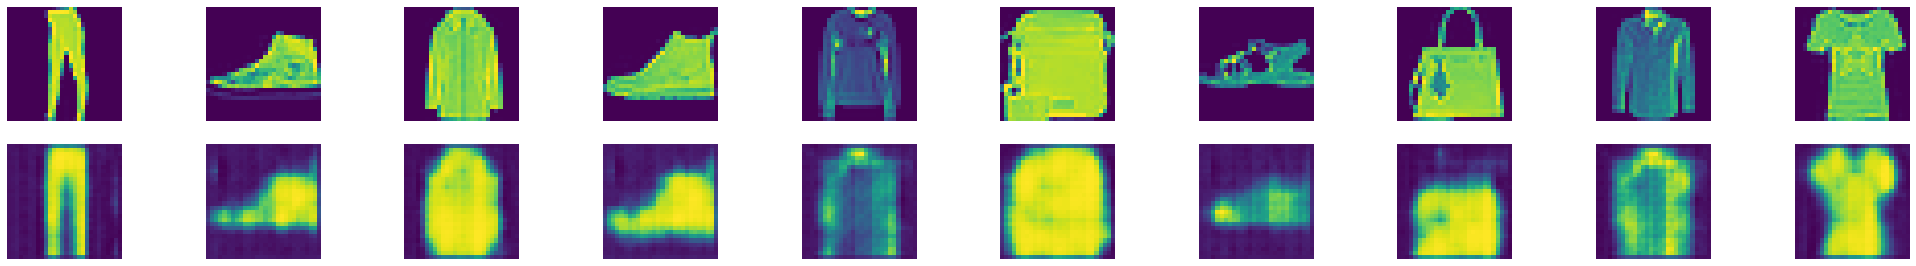

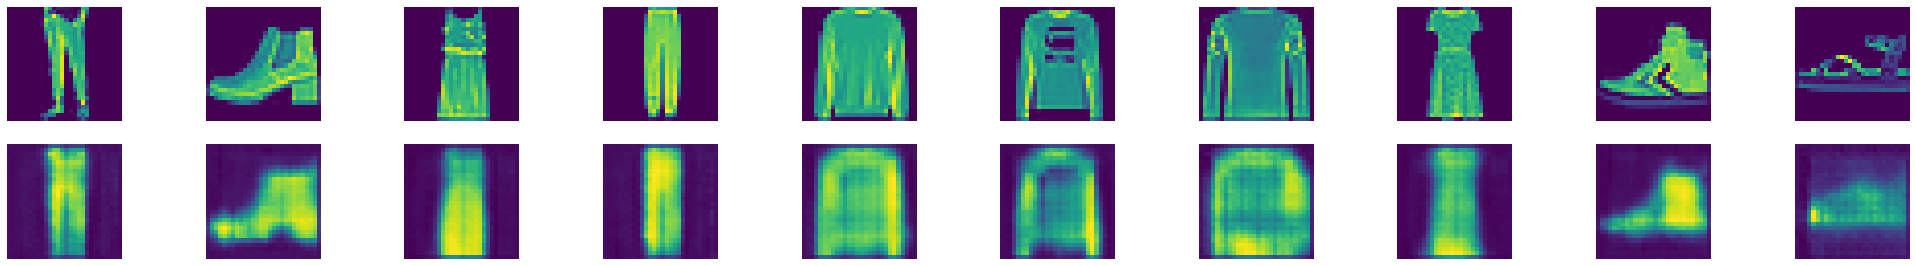

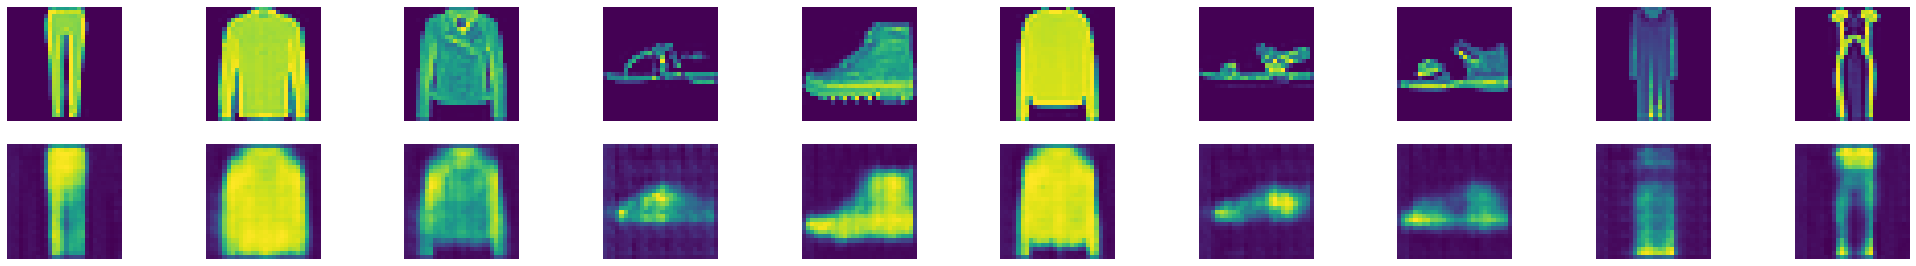

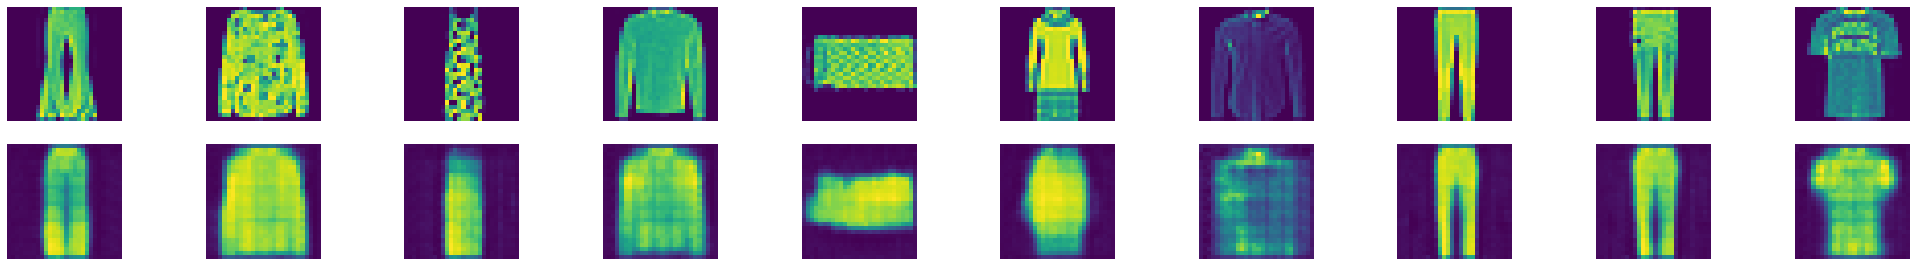

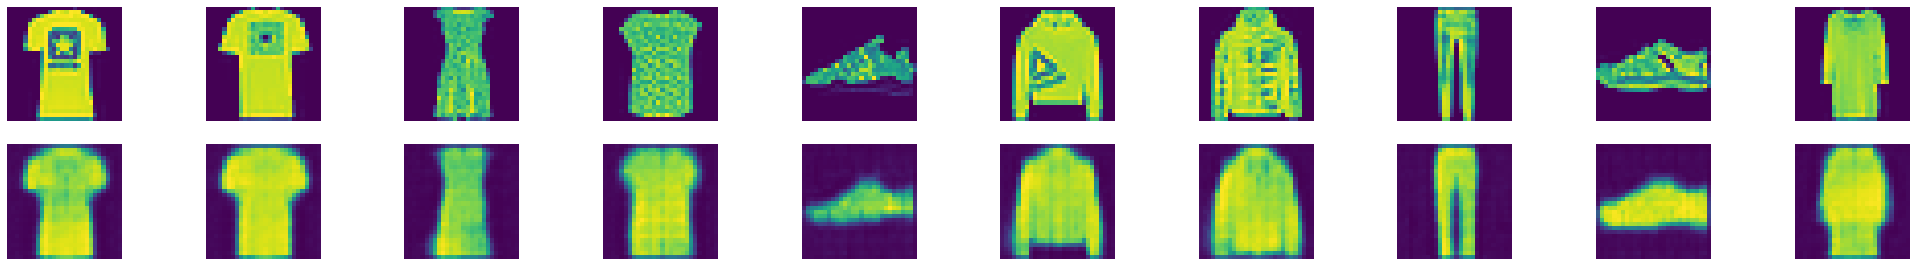

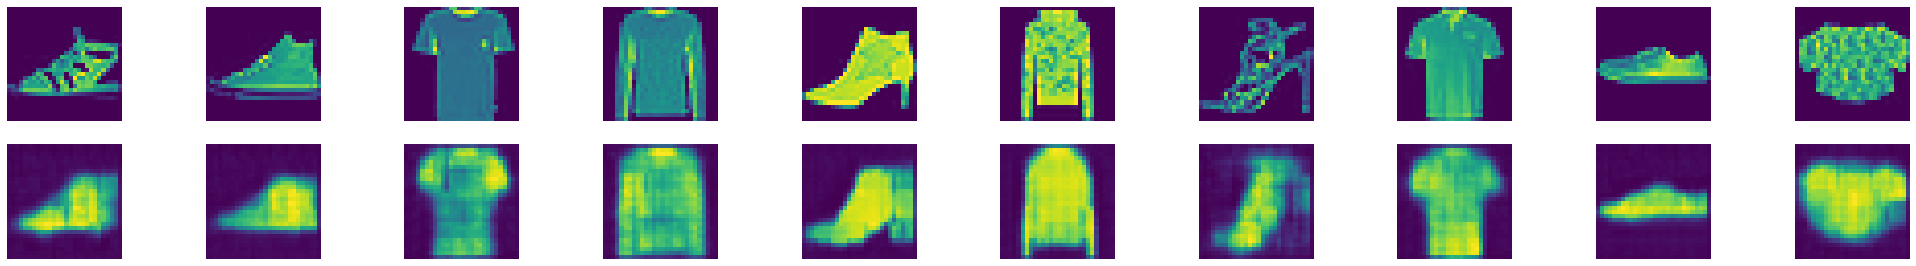

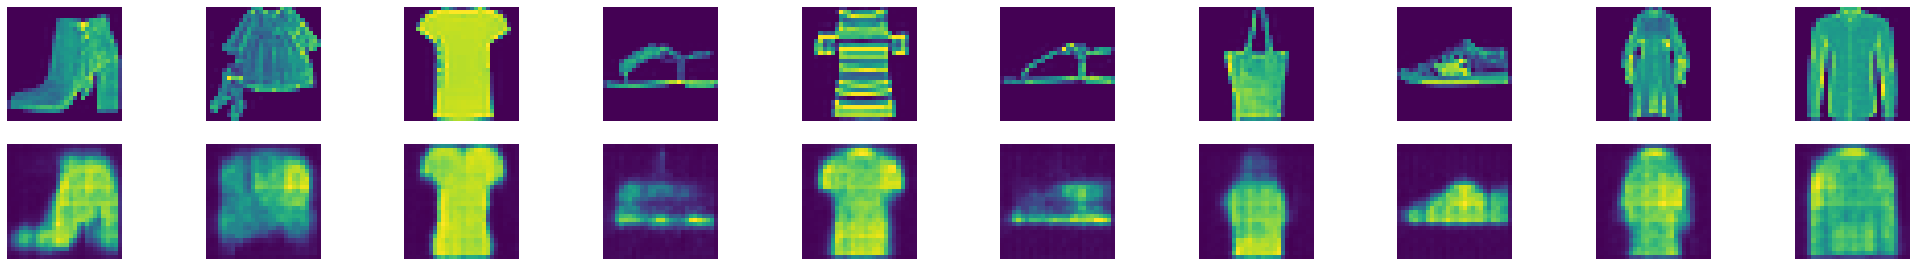

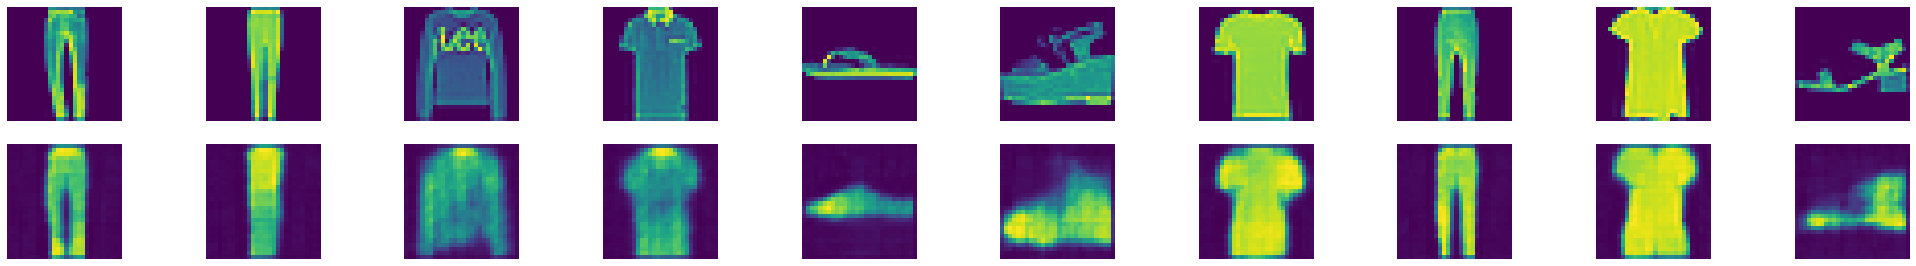

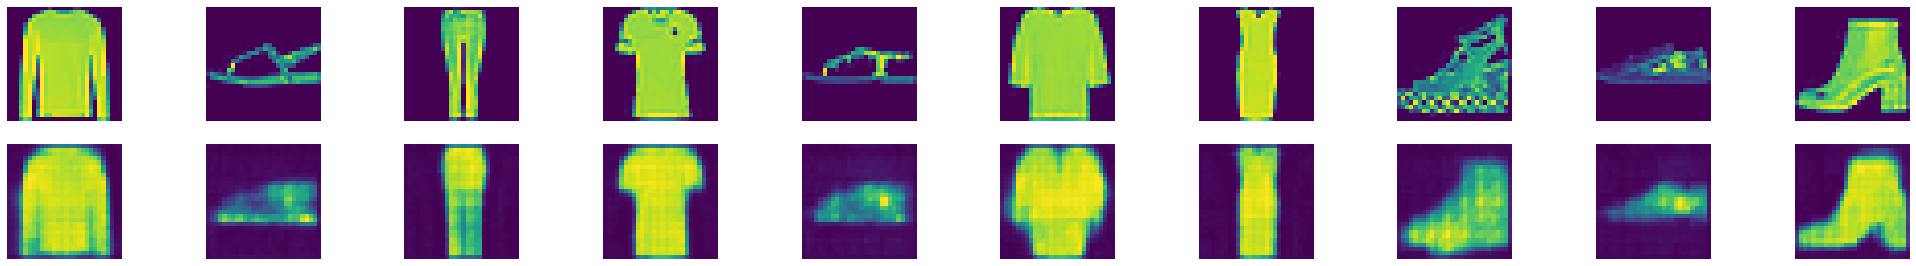

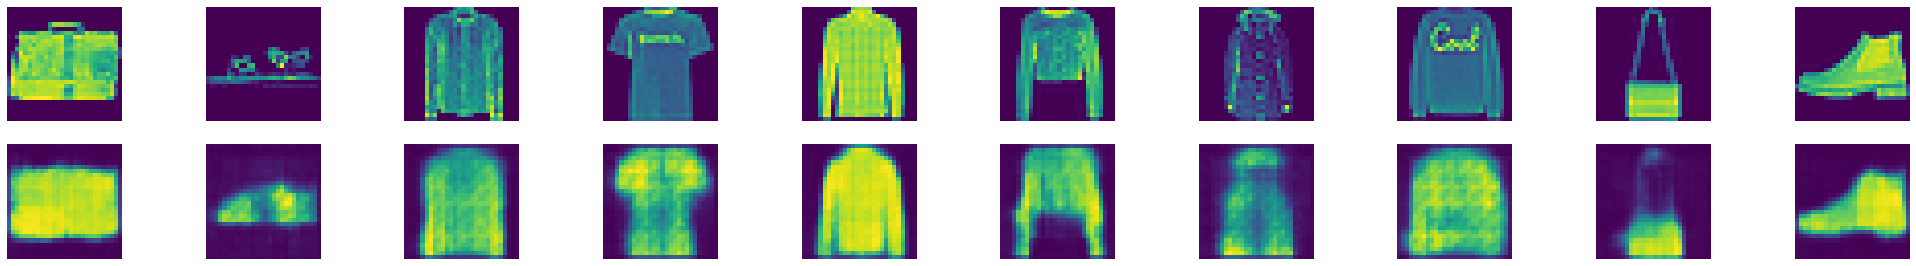

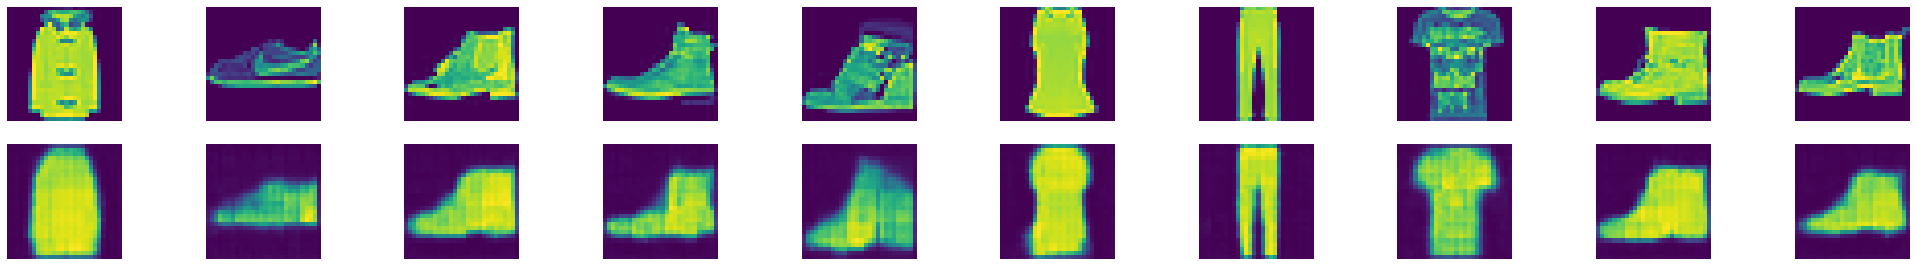

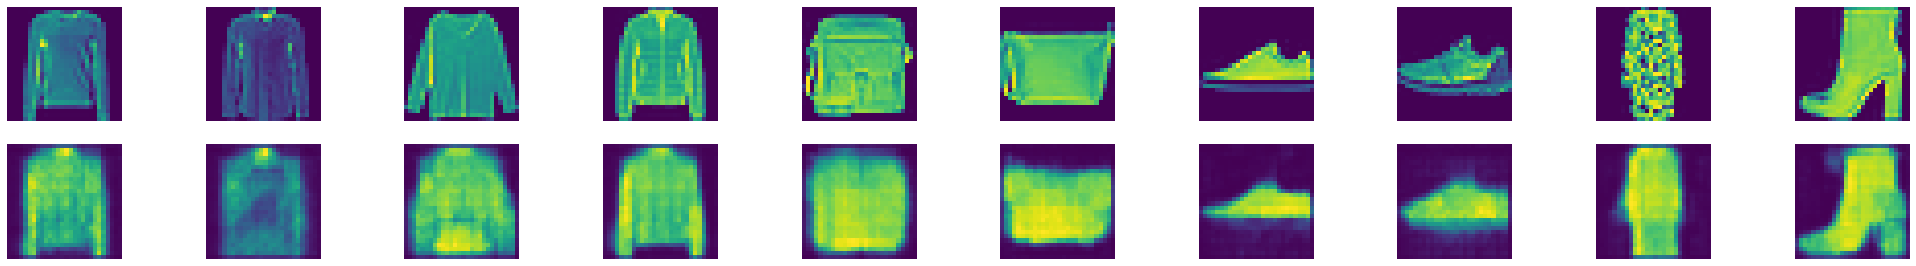

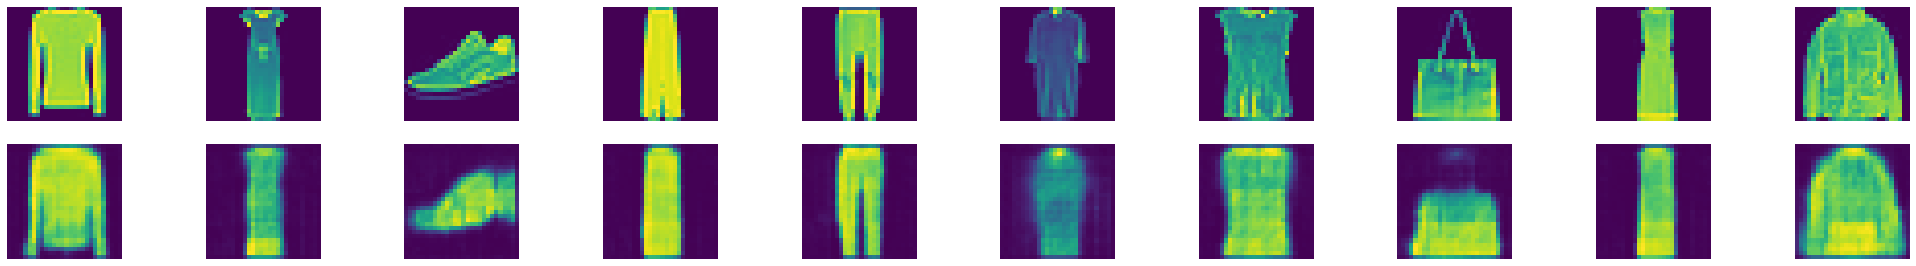

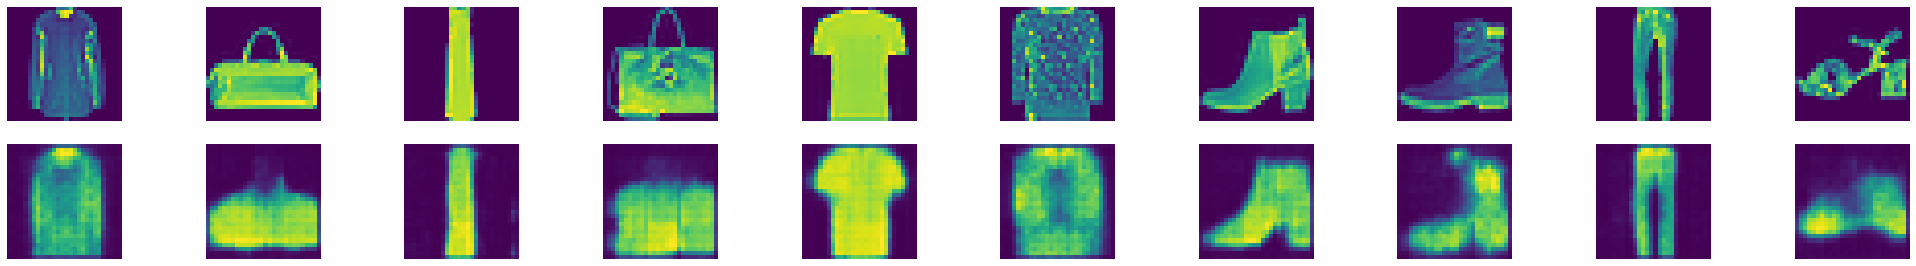

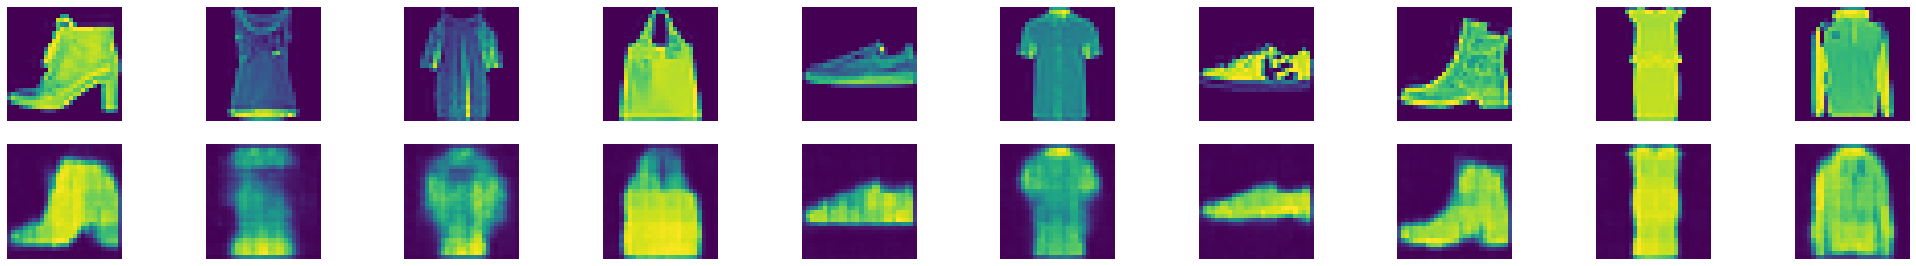

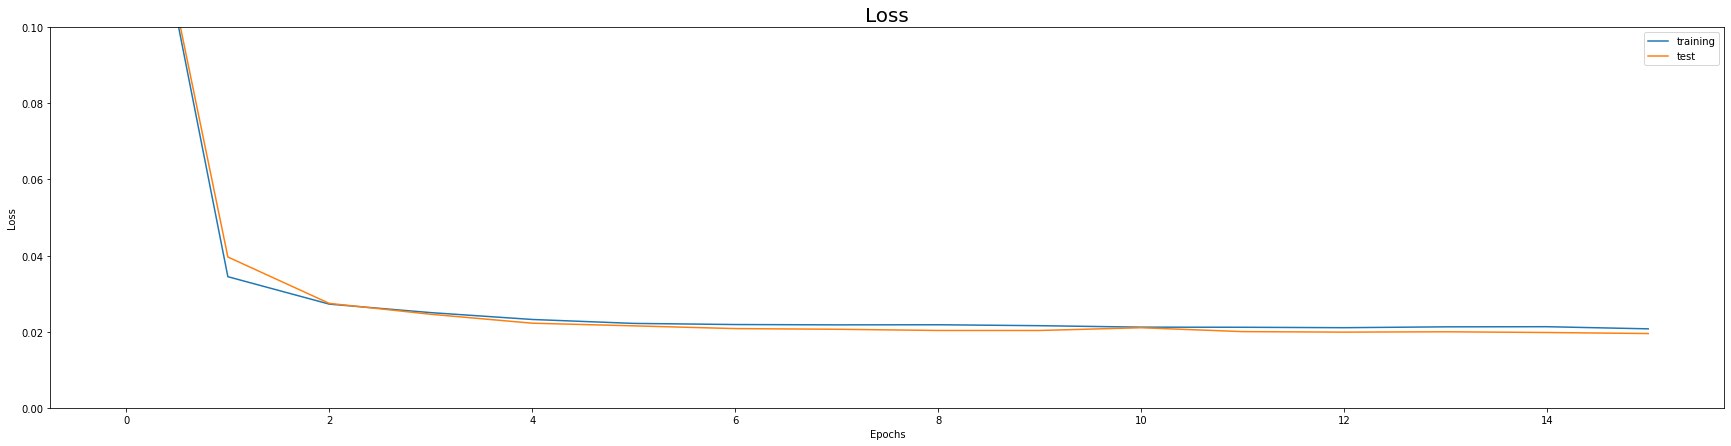

Training the model took 335.44 seconds
Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  69490     
_________________________________________________________________
decoder (Decoder)            multiple                  39396     
Total params: 108,886
Trainable params: 108,254
Non-trainable params: 632
_________________________________________________________________


In [31]:
autoencoder = AutoEncoder()
train(autoencoder)

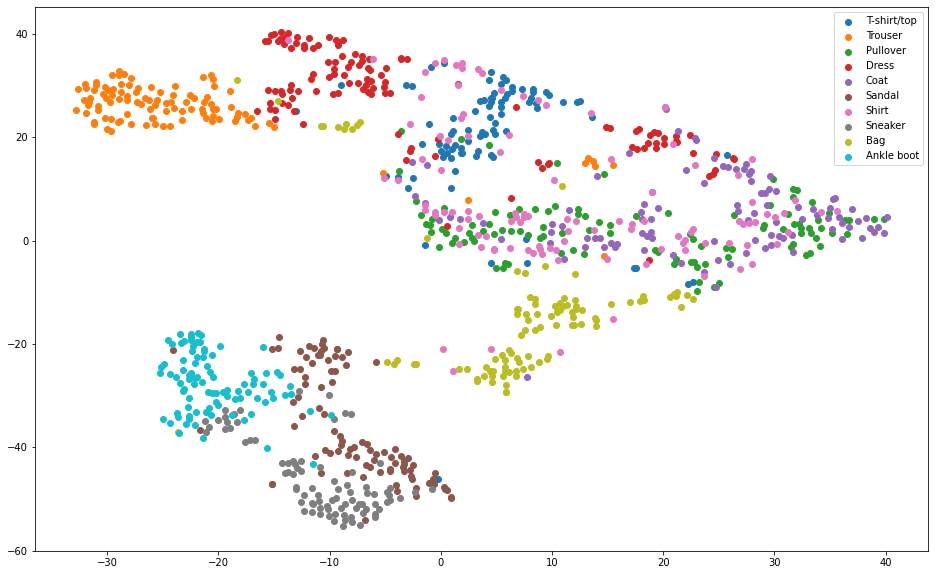

In [33]:
from sklearn.manifold import TSNE

encoder = autoencoder.getEncoder()
decoder = autoencoder.getDecoder()

embedded = []
labels = []
test_dataset_unbatched = test_dataset.unbatch()
test_dataset_unbatched = test_dataset_unbatched.take(1000)

for (image,label) in test_dataset_unbatched:
  embedded.append(np.array(encoder(tf.expand_dims(image,0), training=False)))
  labels.append(label)

embedded = np.squeeze(embedded)

embedded = TSNE(n_components=2).fit_transform(embedded)

x = embedded[:,0]
y = embedded[:,1]

fig, ax = plt.subplots(figsize=(16,10))

for category in np.unique(labels):
  category_index = np.where(labels == category)
  ax.scatter(x[category_index], y[category_index])

plt.legend(labels=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
plt.show()

The results show pretty much what we expected, similar images have similar/close embeddings and in this the data points from the same category tend to cluster together. Also similar categories like sandals and boots are closer together than sandals and T-shirts for example. 


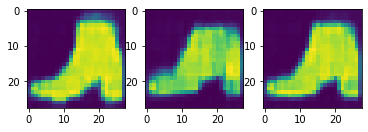

In [43]:
test_dataset_unbatched = test_dataset_unbatched.shuffle(buffer_size=1000)

images = [encoder(tf.expand_dims(image,0), training=False) for (image, label) in test_dataset_unbatched if label == 9][:2]

mixed = decoder(((images[0]+images[1])/2), training=False)


fig, ax = plt.subplots(1,3)
ax[0].imshow(tf.squeeze(decoder(images[0], training=False)))
ax[1].imshow(tf.squeeze(decoder(images[1], training=False)))
ax[2].imshow(tf.squeeze(mixed))

Our autoencoder (to some degree) the identity function and now we can use our trained decoder to generate images from interpolated images / vectors. 